In [31]:
import sys
import math
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

In [33]:
class Braille:
    count = 0

    def __init__(self, rect, value):
        self.rect = rect        # [point of top-left, point of bottom-right]
        self.value = value      # 6bit binary(order : top-left -> bottom-left -> top-right -> bottom-right)
        Braille.count += 1

1) read input image : 48.0 ms


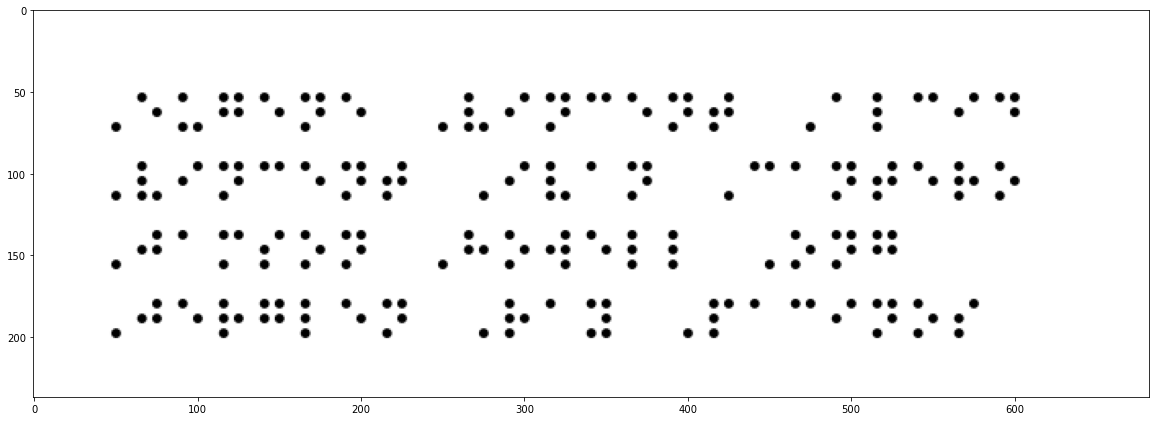

In [35]:
# 0) define param
margin = 10
color_black = np.zeros(3, dtype=np.uint8)

# 1) read input image
start = time.time()
input_img = cv2.imread('test/names.png', cv2.IMREAD_GRAYSCALE) 
end = time.time()
print("1) read input image :", round(((end - start) * 1000), 2), "ms")

'''
scale_percent = 100
width = int(input_img.shape[1] * scale_percent / 100)
height = int(input_img.shape[0] * scale_percent / 100)
dim = (width, height)
 
# resize image
input_img = cv2.resize(input_img, dim, interpolation = cv2.INTER_AREA)
'''

plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.show()

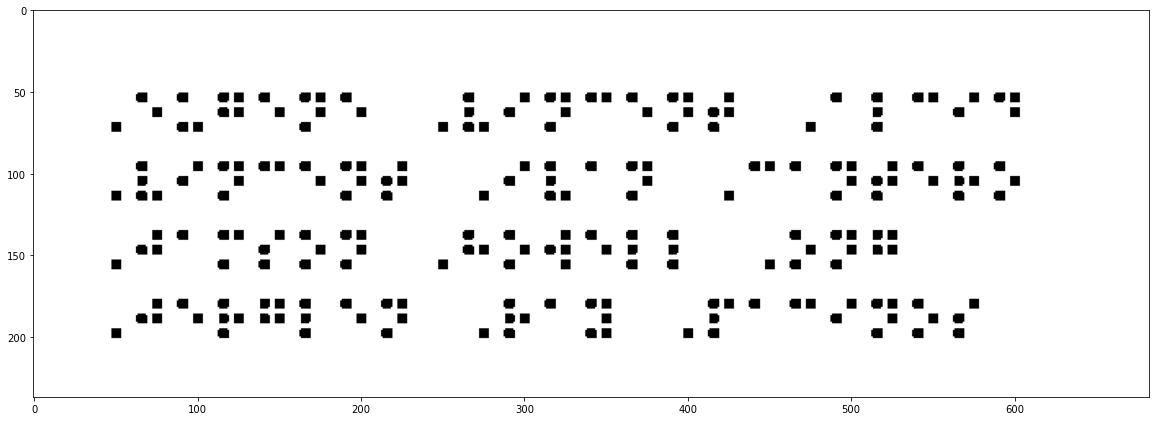

In [37]:
# 2) pre-processing input image
# apply adaptive threshold
start = time.time()
threshold_img = cv2.adaptiveThreshold(input_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)
# apply gaussian blur & erode and then threshold again
kernel = np.ones((3, 3), dtype=np.uint8)  # cpp style : kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
threshold_img = cv2.GaussianBlur(threshold_img, (3, 3), 0)
threshold_img = cv2.erode(threshold_img, kernel)
ret, threshold_img = cv2.threshold(threshold_img, 21, 255, cv2.THRESH_BINARY)
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(threshold_img, cv2.COLOR_BGR2RGB))
plt.show()

2) pre-processing input image : 226.02 ms


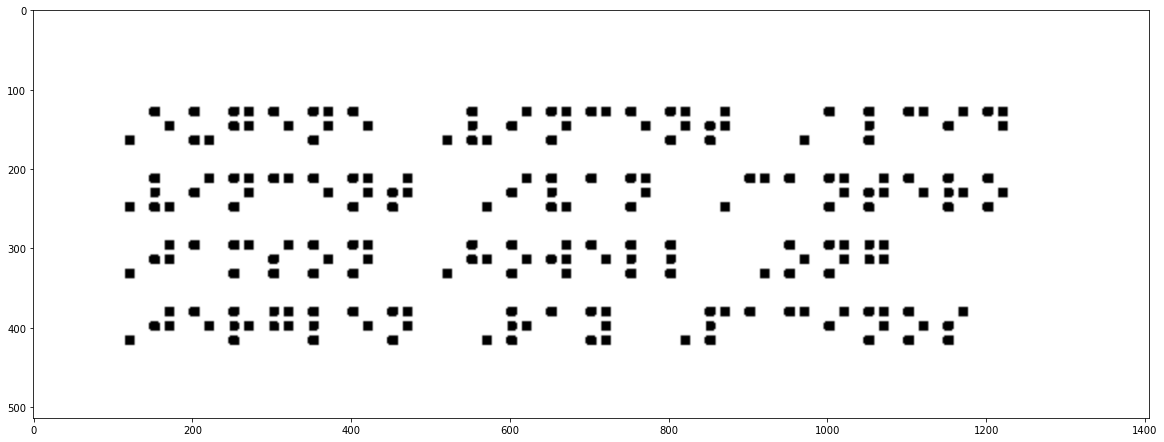

In [39]:
# make margin and resize from original image
v, h = threshold_img.shape
measure_img = np.ones((v + margin * 2, h + margin * 2), dtype=np.uint8) * 255
measure_img[margin:v + margin, margin:h + margin] = threshold_img.copy()
measure_img = cv2.resize(measure_img, (measure_img.shape[1] * 2, measure_img.shape[0] * 2))
end = time.time()
print("2) pre-processing input image :", round(((end - start) * 1000), 2), "ms")

plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(measure_img, cv2.COLOR_BGR2RGB))
plt.show()

3) detect blobs : 129.0 ms


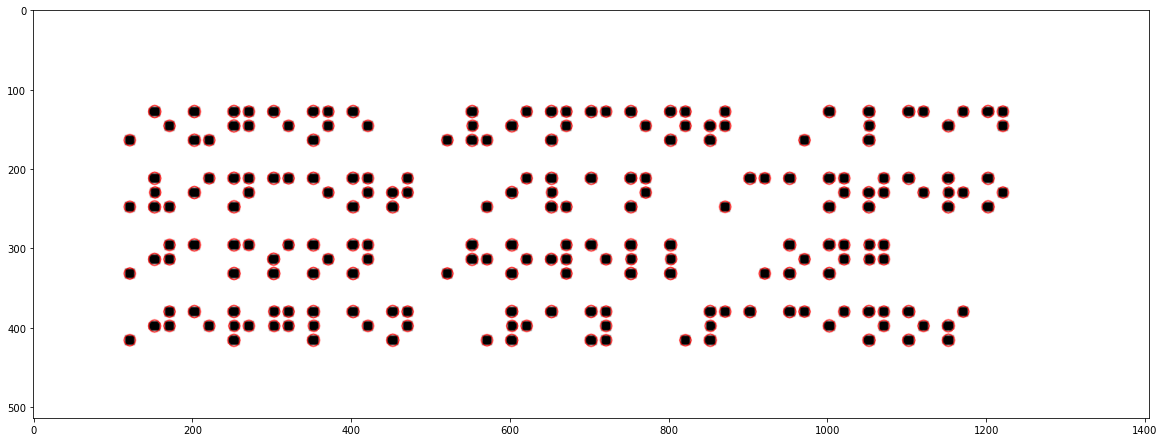

In [41]:
# 3) detect blobs
start = time.time()
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 2.0 * 2.0
params.maxArea = 20.0 * 20.0
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(measure_img)
detected_img = cv2.drawKeypoints(measure_img, keypoints, np.array([]), (0, 0, 255),
                                 cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
end = time.time()
print("3) detect blobs :", round(((end - start) * 1000), 2), "ms")

plt.figure(figsize = (20,20))
plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
plt.show()

4) normalize keypoints to coordinate line set : 33.0 ms


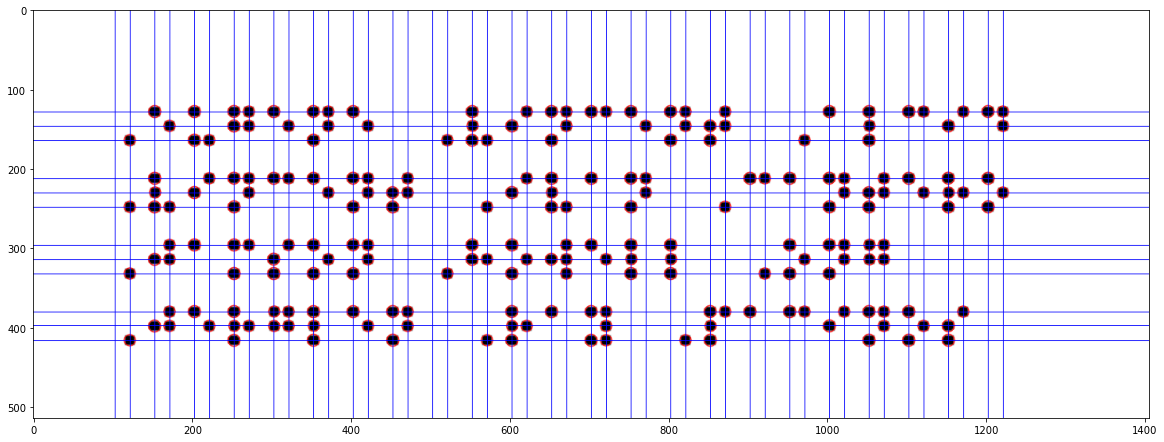

In [43]:
# 4) normalize keypoints to coordinate line set
start = time.time()
blob_size_sum = 0.0
for k in keypoints:
    blob_size_sum += k.size
blob_size = blob_size_sum / len(keypoints)
# print("average of blob size : ", blob_size)
coord_x = np.array([], dtype=np.uint16)
coord_y = np.array([], dtype=np.uint16)
for k in keypoints:
    is_new = True
    for x in coord_x:
        if abs(x - k.pt[0]) < blob_size:
            is_new = False
    if is_new is True:
        coord_x = np.append(coord_x, round(k.pt[0]))
    is_new = True
    for y in coord_y:
        if abs(y - k.pt[1]) < blob_size:
            is_new = False
    if is_new is True:
        coord_y = np.append(coord_y, round(k.pt[1]))
coord_x.sort()
coord_y.sort()


#difference        
coord_x_diffs = []
for i in range(len(coord_x)):
    if i<len(coord_x) and i>0:
        coord_x_diffs.append(coord_x[i]-coord_x[i-1])

min = np.amin(coord_x_diffs)

for i in range(len(coord_x_diffs)):
    if coord_x_diffs[i] > min*2:
        coord_x = np.append(coord_x, coord_x[i+1]-min)       
if coord_x_diffs[0] > min*1.2:
    coord_x = np.append(coord_x, coord_x[0]-min)

        
#coord_x = np.append(coord_x,38)
coord_x.sort()
coord_y.sort()

#Adding Lines to Coordinate Points
coordinate_img = detected_img.copy()
for x in coord_x:
    cv2.line(coordinate_img, (x, 0), (x, coordinate_img.shape[0]), (255, 0, 0))
for y in coord_y:
    cv2.line(coordinate_img, (0, y), (coordinate_img.shape[1], y), (255, 0, 0))
end = time.time()

print("4) normalize keypoints to coordinate line set :", round(((end - start) * 1000), 2), "ms")
plt.figure(figsize = (20,20))
plt.imshow(cv2.cvtColor(coordinate_img, cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
len(coord_x)

46

In [47]:
coord_x

array([ 103,  122,  153,  172,  203,  222,  253,  272,  303,  322,  353,
        372,  403,  422,  453,  472,  503,  522,  553,  572,  603,  622,
        653,  672,  703,  722,  753,  772,  803,  822,  853,  872,  903,
        922,  953,  972, 1003, 1022, 1053, 1072, 1103, 1122, 1153, 1172,
       1203, 1222])

5) move keypoints to the nearest coordinate point : 58.0 ms


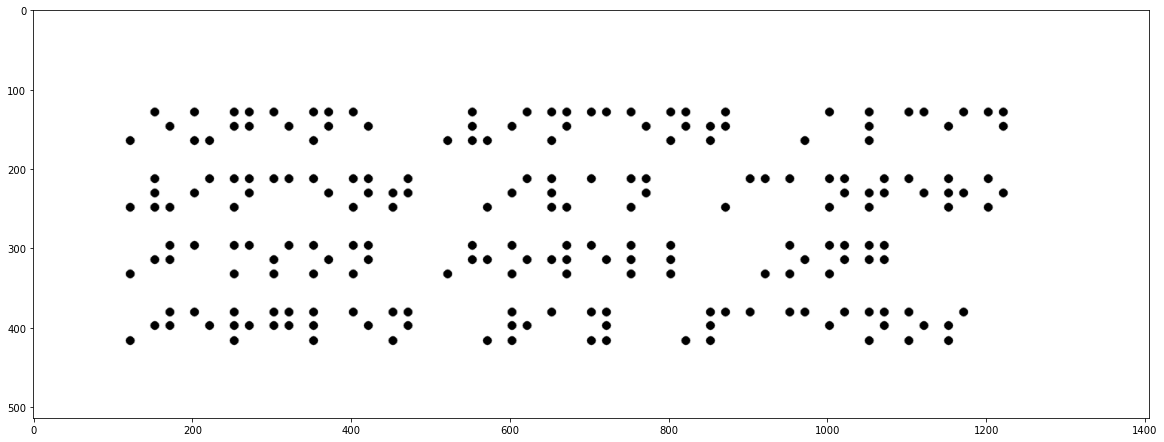

In [49]:
# 5) move keypoints to the nearest coordinate point
start = time.time()
edited_key_array = np.array([], dtype=np.uint16)
for k in keypoints:
    distance_x = detected_img.shape[1] / 2
    distance_y = detected_img.shape[0] / 2
    temp_x = 0
    temp_y = 0
    for x in coord_x:
        if distance_x > abs(k.pt[0] - x):
            distance_x = abs(k.pt[0] - x)
            temp_x = x
    for y in coord_y:
        if distance_y > abs(k.pt[1] - y):
            distance_y = abs(k.pt[1] - y)
            temp_y = y
    # same : after all append, and then edited_key_array = edited_key_array.reshape(-1, 2)
    if edited_key_array.size == 0:
        edited_key_array = np.append(edited_key_array, [temp_x, temp_y])
    else:
        edited_key_array = np.vstack([edited_key_array, [temp_x, temp_y]])
# make image from the edited keypoint set
edit_img = np.ones(detected_img.shape, np.uint8) * 255
circle_size = round(blob_size / 3)
for k in edited_key_array:
    cv2.circle(edit_img, tuple(k), circle_size, (0, 0, 0), -1, cv2.LINE_AA)
end = time.time()
print("5) move keypoints to the nearest coordinate point :", round(((end - start) * 1000), 2), "ms")
plt.figure(figsize = (20,20))
plt.imshow(cv2.cvtColor(edit_img, cv2.COLOR_BGR2RGB))
plt.show()

6) segmentation braille rectangle : 6.0 ms


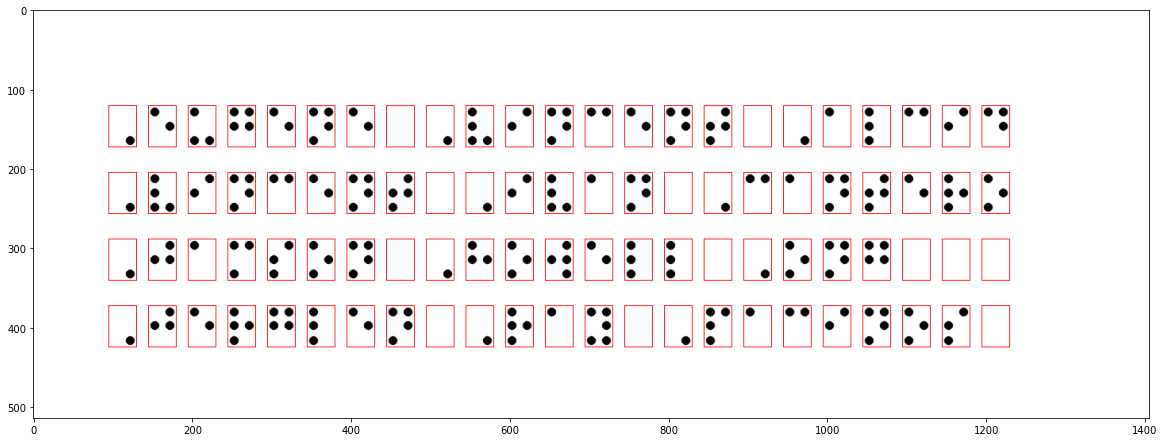

'\n    # comparision with the input image\n    compare_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)\n    width = int(segmentation_img.shape[1] / 2)\n    height = int(segmentation_img.shape[0] / 2)\n    print(width, height)\n    resized_img = segmentation_img.copy()\n    resized_img = cv2.resize(resized_img, (width, height))\n    print(resized_img.shape, compare_img.shape, resized_img[margin:height - margin, margin:width - margin].shape)\n    cv2.addWeighted(compare_img, 0.8, resized_img[margin:height - margin, margin:width - margin], 0.2, 0.0, compare_img)\n    cv2.imshow("(6.5)compare_img", compare_img)\n'

In [51]:
# 6) segmentation braille rectangle
start = time.time()
braille_array = np.array([])
segmentation_img = edit_img.copy()
# ignore to consider the start position of braille
#start_pos = 0
#if (coord_x[1] - coord_x[0]) > (coord_x[2] - coord_x[1]):
#    start_pos = 1
rect_margin = int(math.ceil(blob_size / 2))
rect_width = 0
for i in range(0, coord_y.size, 3):
    for j in range(0, coord_x.size, 2):
        rect = [(coord_x[j] - rect_margin, coord_y[i] - rect_margin),
                (coord_x[j + 1] + rect_margin, coord_y[i + 2] + rect_margin)]
        rect_width += rect[1][0] - rect[0][0]
        cv2.rectangle(segmentation_img, rect[0], rect[1], (0, 0, 255))
        value = np.zeros(6, dtype=np.uint8)
        value_index = 0
        for k in range(2):
            for m in range(3):
                if (edit_img[coord_y[i + m], coord_x[j + k]] == color_black).all():
                    value[value_index] = 1
                value_index += 1
        braille_array = np.append(braille_array, Braille(rect, value))
rect_width /= Braille.count
end = time.time()
print("6) segmentation braille rectangle :", round(((end - start) * 1000), 2), "ms")
plt.figure(figsize = (20,20))
plt.imshow(cv2.cvtColor(segmentation_img, cv2.COLOR_BGR2RGB))
plt.show()
# print("total braille count : ", Braille.count)
# for b in braille_array:
#     print("rect : ", b.rect, " value : ", b.value)

'''
    # comparision with the input image
    compare_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)
    width = int(segmentation_img.shape[1] / 2)
    height = int(segmentation_img.shape[0] / 2)
    print(width, height)
    resized_img = segmentation_img.copy()
    resized_img = cv2.resize(resized_img, (width, height))
    print(resized_img.shape, compare_img.shape, resized_img[margin:height - margin, margin:width - margin].shape)
    cv2.addWeighted(compare_img, 0.8, resized_img[margin:height - margin, margin:width - margin], 0.2, 0.0, compare_img)
    cv2.imshow("(6.5)compare_img", compare_img)
'''

7) make result image : 14.0 ms


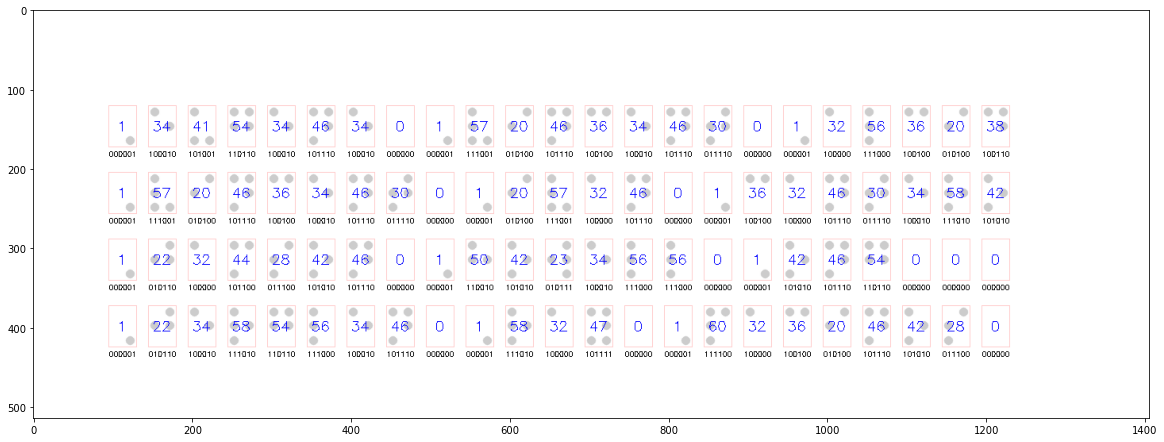

In [53]:
# 7) make result image
start = time.time()
result_img = np.ones(segmentation_img.shape, dtype=np.uint8) * 255
cv2.addWeighted(result_img, 0.8, segmentation_img, 0.2, 0.0, result_img)
font_face = cv2.FONT_HERSHEY_SIMPLEX
font_scale = rect_width / 60.0
font_thickness = round(font_scale * 2)

#Labelling
for b in braille_array:
    tl = np.array(b.rect[0])
    br = np.array(b.rect[1])
    center = np.mean(np.array([tl, br]), axis=0, dtype=np.uint16)
    bl = np.array([b.rect[0][0], b.rect[1][1] + round(font_scale * 20)])
    value_str = ''
    int_str = 0
    for t in b.value:
        value_str += str(t)
        int_str = int(value_str, 2)
    center[0] -= round(cv2.getTextSize(str(int_str), font_face, font_scale, font_thickness)[0][0] / 2)
    center[1] += round(cv2.getTextSize(str(int_str), font_face, font_scale, font_thickness)[0][1] / 2)
    cv2.putText(result_img, value_str, tuple(bl), font_face, font_scale / 2, (0, 0, 0), font_thickness)
    cv2.putText(result_img, str(int_str), tuple(center), font_face, font_scale, (255, 0, 0), font_thickness)
end = time.time()

print("7) make result image :", round(((end - start) * 1000), 2), "ms")
plt.figure(figsize = (20,20))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()

In [55]:
coord_x

array([ 103,  122,  153,  172,  203,  222,  253,  272,  303,  322,  353,
        372,  403,  422,  453,  472,  503,  522,  553,  572,  603,  622,
        653,  672,  703,  722,  753,  772,  803,  822,  853,  872,  903,
        922,  953,  972, 1003, 1022, 1053, 1072, 1103, 1122, 1153, 1172,
       1203, 1222])

In [56]:
coord_y

array([128, 146, 164, 212, 230, 248, 296, 314, 332, 380, 397, 416])

In [57]:
coord_x_diffs = []
for i in range(len(coord_x)):
    if i<len(coord_x) and i>0:
        coord_x_diffs.append(coord_x[i]-coord_x[i-1])

x_min = np.amin(coord_x_diffs)
x_max = np.amax(coord_x_diffs)

coord_y_diffs = []
for i in range(len(coord_y)):
    if i<len(coord_y) and i>0:
        coord_y_diffs.append(coord_y[i]-coord_y[i-1])

y_min = np.amin(coord_y_diffs)
y_max = np.amax(coord_y_diffs)

In [58]:
x_crop = coord_x[0:2] #+ x_max + x_min
y_crop = coord_y[0:3] #+ y_max + y_min

In [59]:
y_crop

array([128, 146, 164])

In [60]:
ax = 0
bx = 2
new_x = []
for x in range(int(len(coord_x))):
    new_x.append(coord_x[ax])
    ax+=1
    bx+=2

In [61]:
len(new_x)

46

In [62]:
ay = 0
by = 0
new_y = []
for y in range(int(len(coord_y))):
    if by == 0 and ay<int(len(coord_y)) and by<=int(len(coord_y))-1:
        new_y.append(coord_y[ay])
        ay+=2
        by+=1
    elif by >= 1 and by<=int(len(coord_y))-1:
        new_y.append(coord_y[ay])
        ay+=1
        by=0
    else:
        by=0

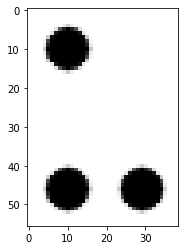

In [63]:
#Initial [30:74,35:58]
ay = new_y[0] 
by = new_y[1]
ax = new_x[4]
bx = new_x[5]
crop = edit_img[ay-10:by+10,ax-10:bx+10]
plt.imshow(crop)

In [64]:
from __future__ import print_function
import os
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [65]:
from tensorflow import keras
model_braille = keras.models.load_model('modelBrailleScCNN1.h5')

In [66]:
characters={
    #letters
    0:'a', 1:'b', 2:'c', 3:'d', 4:'e',
    5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 
    10:'k', 11:'l', 12:'m', 13:'n', 14:'o',
    15:'p', 16:'q', 17:'r', 18:'s', 
    
    #Characters
    19:'SC1', 20:'SC10', 21:'SC11',
    22:'SC12', 23:'SC13', 24:'SC14', 25:'SC15',
    26:'SC16', 27:'SC17', 28:'SC18', 29:'SC19',
    
    30:'SC2', 31:'SC20', 32:'SC21', 33:'SC22',
    34:'SC23', 35:'SC24', 36:'SC25', 37:'SC26',
    38:'SC27', 39:'SC28', 40:'SC29', 
    
    41:'SC3', 42:'SC30', 43:'SC31', 44:'SC32', 
    45:'SC33', 46:'SC34', 
    
    47:'SC4', 48:'SC5', 49:'SC6',
    50:'SC7', 51:'SC8', 52:'SC9',
    
    #Letters cont.
    53:'t',
    54:'u',
    55:'v', 56:'w', 57:'x', 58:'y', 59:'z',
}

In [67]:
crop.shape

(56, 39, 3)

In [68]:
crop_new = cv2.resize(crop,(28,28))

In [69]:
crop_new.shape

(28, 28, 3)

In [70]:
crop_final=np.expand_dims(crop_new,axis=0)
crop_final.shape

(1, 28, 28, 3)

In [71]:
crop_final=np.array(crop_final)
crop_final.shape

(1, 28, 28, 3)

In [72]:
pred = (model_braille.predict(crop_final) > 0.5).astype("int32")

In [73]:
pred

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [74]:
predOne = np.amax(pred)
pred_final = np.where(pred == predOne)
predVal = pred_final[1]
print(str(predVal[0]) + ':' + str(characters[predVal[0]]))

54:u


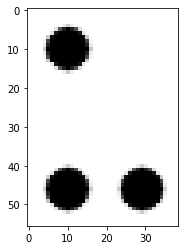

In [75]:
plt.imshow(crop)

### Testing (Single Cell)

In [76]:
def prediction(crop):
    ##Library Implementations
    import cv2
    import tensorflow as tf
    import matplotlib.pyplot as plt
    from tensorflow import keras
    model_braille = keras.models.load_model('modelBrailleScCNN1.h5')
    
    ##Image Processing before feeding to the model
    crop_new = cv2.resize(crop,(28,28))
    crop_final=np.expand_dims(crop_new,axis=0)
    crop_final=np.array(crop_final)
    
    ##Prediction Process
    pred = (model_braille.predict(crop_final) > 0.5).astype("int32")
    
    predOne = np.amax(pred)
    pred_final = np.where(pred == predOne)
    predVal = pred_final[1]
    return predVal

In [77]:
def characters(val):
    characters={
    ##letters
    0:'a', 1:'b', 2:'c', 3:'d', 4:'e',
    5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 
    10:'k', 11:'l', 12:'m', 13:'n', 14:'o',
    15:'p', 16:'q', 17:'r', 18:'s', 
    
    ##Special Characters
    19:'SC1', 20:'SC10', 21:'SC11',
    22:'SC12', 23:'SC13', 24:'SC14', 25:'SC15',
    26:'SC16', 27:'SC17', 28:'SC18', 29:'SC19',
    
    30:'SC2', 31:'SC20', 32:'SC21', 33:'SC22',
    34:'SC23', 35:'SC24', 36:'SC25', 37:'SC26',
    38:'SC27', 39:'SC28', 40:'SC29', 
    
    41:'SC3', 42:'SC30', 43:'SC31', 44:'SC32', 
    45:'SC33', 46:'SC34', 
    
    47:'SC4', 48:'SC5', 49:'SC6',
    50:'SC7', 51:'SC8', 52:'SC9',
    
    ##Letters cont.
    53:'t',
    54:'u',
    55:'v', 56:'w', 57:'x', 58:'y', 59:'z',
    }
    
    charVal = str(characters[val])
    return charVal

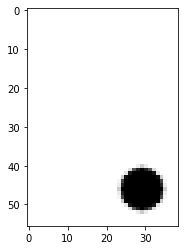

In [78]:
###Coordinates for Cropping
ay = new_y[0] 
by = new_y[1]
ax = new_x[16]
bx = new_x[17]
crop = edit_img[ay-10:by+10,ax-10:bx+10]
plt.imshow(crop)

In [79]:
finalOut = prediction(crop)
finalOut

array([41], dtype=int64)

### Testing (Multiple Cells)

In [80]:
coord_x

array([ 103,  122,  153,  172,  203,  222,  253,  272,  303,  322,  353,
        372,  403,  422,  453,  472,  503,  522,  553,  572,  603,  622,
        653,  672,  703,  722,  753,  772,  803,  822,  853,  872,  903,
        922,  953,  972, 1003, 1022, 1053, 1072, 1103, 1122, 1153, 1172,
       1203, 1222])

In [81]:
new_y

[128, 164, 212, 248, 296, 332, 380, 416]

In [82]:
len(new_x)

46

In [83]:
start = time.time()
predSen = []
axx,bxx,ayy,byy = 0,1,0,1
ay = new_y[ayy]
by = new_y[byy]
for y in range(int(len(new_y)/2)):
    print("----- Row",ay,by,"-----")
    if byy < int(len(new_y)) and bxx < int(len(new_x)):
        for x in range(int(len(new_x)/2)):
            ax = new_x[axx]
            bx = new_x[bxx]
            ay = new_y[ayy]
            by = new_y[byy]
            crop = edit_img[ay-10:by+10,ax-10:bx+10]
            finalOut = prediction(crop)
            predSen.append(finalOut[0])
            print(ax,bx,"|",x,y,"|",axx,bxx,ayy,byy,"|",finalOut)
            axx+=2
            bxx+=2
            if bxx == int(len(new_x))-2:
                ayy+=2
                byy+=2
            else:
                placeholder = 0
    else:
        placeholder = 0
    axx=0
    bxx=1
    ayy+=2
    byy+=2
    
end = time.time()
print("8) Prediction Processing :", round(((end - start) * 1000), 2), "ms")

----- Row 128 164 -----
103 122 | 0 0 | 0 1 0 1 | [41]
153 172 | 1 0 | 2 3 0 1 | [4]
203 222 | 2 0 | 4 5 0 1 | [54]
253 272 | 3 0 | 6 7 0 1 | [6]
303 322 | 4 0 | 8 9 0 1 | [4]
353 372 | 5 0 | 10 11 0 1 | [13]
403 422 | 6 0 | 12 13 0 1 | [4]
453 472 | 7 0 | 14 15 0 1 | [0]
503 522 | 8 0 | 16 17 0 1 | [41]
553 572 | 9 0 | 18 19 0 1 | [55]
603 622 | 10 0 | 20 21 0 1 | [8]
653 672 | 11 0 | 22 23 0 1 | [13]
703 722 | 12 0 | 24 25 0 1 | [2]
753 772 | 13 0 | 26 27 0 1 | [4]
803 822 | 14 0 | 28 29 0 1 | [13]
853 872 | 15 0 | 30 31 0 1 | [53]
903 922 | 16 0 | 32 33 0 1 | [0]
953 972 | 17 0 | 34 35 0 1 | [41]
1003 1022 | 18 0 | 36 37 0 1 | [0]
1053 1072 | 19 0 | 38 39 0 1 | [11]
1103 1122 | 20 0 | 40 41 0 1 | [2]
1153 1172 | 21 0 | 42 43 0 1 | [8]
1203 1222 | 22 0 | 44 45 0 1 | [3]
----- Row 128 164 -----
103 122 | 0 1 | 0 1 2 3 | [41]
153 172 | 1 1 | 2 3 2 3 | [55]
203 222 | 2 1 | 4 5 2 3 | [8]
253 272 | 3 1 | 6 7 2 3 | [13]
303 322 | 4 1 | 8 9 2 3 | [2]
353 372 | 5 1 | 10 11 2 3 | [4]
403 422 

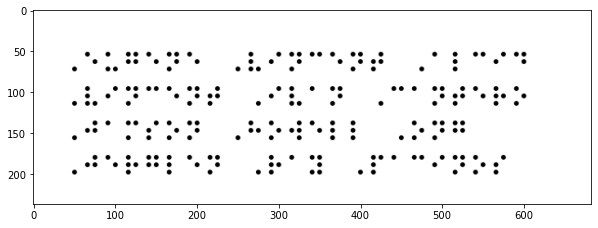

SC3eugeneaSC3vincentaSC3alcidSC3vincentaSC3ivanaSC3canteroSC3jamsonaSC3howellaSC3ongaaaSC3jerglenaSC3rayaSC3pacinosa


In [84]:
finalText = ""
for x in range(len(predSen)):
    fin = predSen[x]
    finalChar = characters(fin)
    finalText += finalChar

plt.figure(figsize = (10,5))
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.show()

print(finalText)

[ Final Result ]

SC3 = Capital
a = spaces (model edit)

"Each time they w <br>
they brought with <br>
because no one lo" <br>